In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Cấu hình hiển thị
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import warnings
warnings.filterwarnings('ignore')

# Tải đồ thị G_clean
input_path = r"C:\Users\Dell\Downloads\facebook_combined_cleaned.txt"

print(f"Loading G_clean from: {input_path}")
# Đọc file (giả sử định dạng: source target)
G_clean = nx.read_edgelist(input_path, create_using=nx.Graph(), nodetype=str)

print(f"Đồ thị đã tải: {G_clean.number_of_nodes()} nodes, {G_clean.number_of_edges()} edges.")

c:\Users\Dell\miniconda3\envs\ds102\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading G_clean from: C:\Users\Dell\Downloads\facebook_combined_cleaned.txt
Đồ thị đã tải: 4039 nodes, 88234 edges.


# 1. Chạy Node2Vec (Embedding)

In [2]:
# Cấu hình Node2Vec
# p=1, q=1: Cân bằng giữa khám phá địa phương (BFS) và sâu (DFS) để nắm bắt cấu trúc cộng đồng tốt nhất.
node2vec = Node2Vec(G_clean, 
                    dimensions=64,   # Kích thước vector 
                    walk_length=30,  # Độ dài mỗi bước đi
                    num_walks=200,   # Số lần đi từ mỗi nút
                    workers=4,       # Số nhân CPU sử dụng
                    p=1, q=1,
                    quiet=False)     # Hiện tiến độ

# Huấn luyện mô hình
model_n2v = node2vec.fit(window=10, min_count=1, batch_words=4)

# Lấy vector embedding cho tất cả các nút
# Sắp xếp node ID để đảm bảo thứ tự khớp với DataFrame sau này
nodes_list = sorted(list(G_clean.nodes()))
embeddings = np.array([model_n2v.wv[n] for n in nodes_list])

print(f"Đã tạo Embeddings với kích thước: {embeddings.shape}")
# Lưu embedding nếu cần dùng lại sau này
model_n2v.wv.save_word2vec_format("facebook_node2vec.emb")

Computing transition probabilities: 100%|██████████| 4039/4039 [00:30<00:00, 132.16it/s]


Đã tạo Embeddings với kích thước: (4039, 64)


# 2. Phân cụm Vai trò (K-Means Clustering)

- Dùng Elbow Method để xem nên chia thành bao nhiêu nhóm vai trò là hợp lý, sau đó chạy K-Means

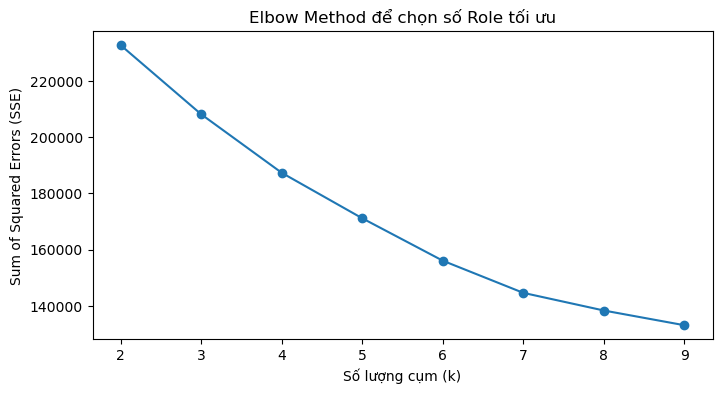

Tiến hành phân cụm với k=3...
Phân cụm hoàn tất!
Cluster_Role
0    1898
2    1353
1     788
Name: count, dtype: int64


In [3]:
# 1. Tìm số cụm tối ưu (Elbow Method)
sse = []
k_range = range(2, 10) # Thử từ 2 đến 9 cụm

# Chuẩn hóa dữ liệu trước khi cluster 
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings_scaled)
    sse.append(kmeans.inertia_)

# Vẽ biểu đồ Elbow
plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method để chọn số Role tối ưu')
plt.show()

# --- CHỌN K VÀ CHẠY CLUSTERING ---
# Chọn k=3 (Hubs, Bridges, Others/Peripherals) để dễ phân tích.
k_optimal = 3 
print(f"Tiến hành phân cụm với k={k_optimal}...")

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings_scaled)

# Tạo DataFrame kết quả
df_roles = pd.DataFrame({
    'NodeID': nodes_list,
    'Cluster_Role': clusters
})

print("Phân cụm hoàn tất!")
print(df_roles['Cluster_Role'].value_counts())

# 3. Giải mã Vai trò (Role Interpretation)

- Chứng minh giả thuyết: "Nhóm nào là Hub? Nhóm nào là Bridge?" bằng cách so sánh đặc tính trung bình của từng cụm với Degree và Betweenness thực tế.

In [5]:
# 1. Đường dẫn đến file Role Table của giai đoạn 2
role_table_path = r"C:\Users\Dell\Downloads\role_table.csv"

try:
    # 2. Đọc file metrics
    df_metrics = pd.read_csv(role_table_path)
    
    # 3. Xử lý tên cột
    id_col = 'NodeID' 
    deg_col = 'DegreeCentrality'
    if 'Betweenness' in df_metrics.columns:
        bet_col = 'Betweenness'
    elif 'BetweennessCentrality' in df_metrics.columns:
        bet_col = 'BetweennessCentrality'

    print(f"-> Sử dụng các cột: ID='{id_col}', Degree='{deg_col}', Betweenness='{bet_col}'")

    # 4. Chuẩn hóa ID để ghép bảng
    df_metrics[id_col] = df_metrics[id_col].astype(str)
    df_roles['NodeID'] = df_roles['NodeID'].astype(str)
    
    # 5. Ghép bảng Cluster (từ Node2Vec) với bảng Metrics (từ CSV)
    # Chỉ lấy các cột cần thiết
    df_final = pd.merge(df_roles, df_metrics[[id_col, deg_col, bet_col]], 
                        left_on='NodeID', right_on=id_col, how='inner')
    
    # Cập nhật lại df_roles
    df_roles = df_final
    print(f"✅ Đã ghép thành công! Kích thước bảng sau khi ghép: {df_roles.shape}")

    # 6. Tính trung bình chỉ số theo từng Cụm (Cluster)
    role_analysis = df_roles.groupby('Cluster_Role')[[deg_col, bet_col]].mean()
    role_counts = df_roles['Cluster_Role'].value_counts().rename("Count")
    role_analysis = pd.concat([role_analysis, role_counts], axis=1)

    print("\n--- BẢNG PHÂN TÍCH VAI TRÒ (ROLE PROFILE) ---")
    print(role_analysis)

    # 7. Tự động định danh (Insight)
    print("\n--- KẾT LUẬN & ĐỊNH DANH ---")
    
    # Tìm cụm có chỉ số cao nhất
    id_max_deg = role_analysis[deg_col].idxmax()
    id_max_bet = role_analysis[bet_col].idxmax()

    print(f"1. Nhóm HUBS (Người nổi tiếng): Cụm {id_max_deg}")
    print(f"   -> Có {deg_col} trung bình cao nhất ({role_analysis.loc[id_max_deg, deg_col]:.4f}).")
    
    print(f"2. Nhóm BRIDGES (Người cầu nối): Cụm {id_max_bet}")
    print(f"   -> Có {bet_col} trung bình cao nhất ({role_analysis.loc[id_max_bet, bet_col]:.4f}).")
    
    if id_max_deg == id_max_bet:
        print("   (Lưu ý: Trong mạng lưới này, nhóm Hubs cũng đồng thời nắm giữ vai trò cầu nối chính)")
        
    others = [idx for idx in role_analysis.index if idx != id_max_deg and idx != id_max_bet]
    if others:
            print(f"3. Nhóm PERIPHERALS (Vùng rìa): Các cụm {others}")
            print("   -> Các chỉ số thấp hơn, đóng vai trò người dùng thông thường.")

except FileNotFoundError:
    print(f"❌ Lỗi: Không tìm thấy file tại {role_table_path}")
except ValueError as ve:
    print(f"❌ Lỗi dữ liệu: {ve}")
    print(f"   Các cột hiện có: {list(df_metrics.columns)}")
except Exception as e:
    print(f"❌ Có lỗi xảy ra: {e}")

-> Sử dụng các cột: ID='NodeID', Degree='DegreeCentrality', Betweenness='Betweenness'
✅ Đã ghép thành công! Kích thước bảng sau khi ghép: (4039, 4)

--- BẢNG PHÂN TÍCH VAI TRÒ (ROLE PROFILE) ---
              DegreeCentrality  Betweenness  Count
Cluster_Role                                      
0                      0.01071      0.00053   1898
1                      0.00934      0.00065    788
2                      0.01183      0.00087   1353

--- KẾT LUẬN & ĐỊNH DANH ---
1. Nhóm HUBS (Người nổi tiếng): Cụm 2
   -> Có DegreeCentrality trung bình cao nhất (0.0118).
2. Nhóm BRIDGES (Người cầu nối): Cụm 2
   -> Có Betweenness trung bình cao nhất (0.0009).
   (Lưu ý: Trong mạng lưới này, nhóm Hubs cũng đồng thời nắm giữ vai trò cầu nối chính)
3. Nhóm PERIPHERALS (Vùng rìa): Các cụm [0, 1]
   -> Các chỉ số thấp hơn, đóng vai trò người dùng thông thường.


# 4. Trực quan hóa Vai trò

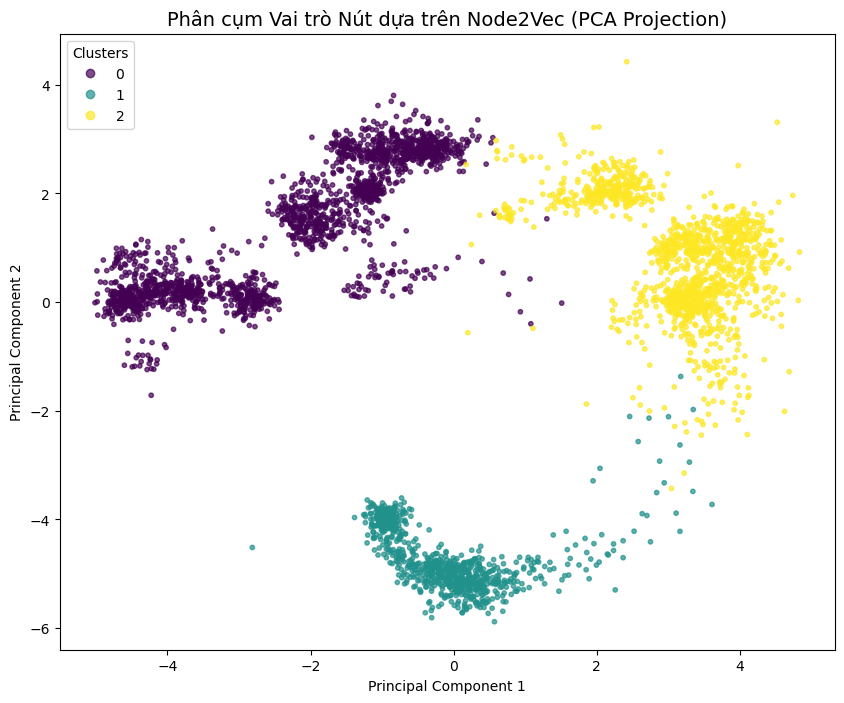

In [6]:
# Giảm chiều dữ liệu từ 64 chiều xuống 2 chiều để vẽ
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(embeddings_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(node_embeddings_2d[:, 0], 
                      node_embeddings_2d[:, 1], 
                      c=df_roles['Cluster_Role'], 
                      cmap='viridis', 
                      alpha=0.7,
                      s=10)

plt.title('Phân cụm Vai trò Nút dựa trên Node2Vec (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()